# Homework 2: Trees and Calibration


## Instructions

Please push the .ipynb, .py, and .pdf to Github Classroom prior to the deadline. Please include your UNI as well.

**Make sure to use the dataset that we provide in CourseWorks/Classroom.**

**There are a lot of applied questions based on the code results. Please make sure to answer them all. These are primarily to test your understanding of the results your code generate (similar to any Data Science/ML case study interviews).**

## Name:  Jessica (Youjia) Li

## UNI: yl5542

## The Dataset

### Description
This dataset contains details of individual relating to their health. The target is stored in **strokes** column which is binary variable indicating either 0 or 1. The goal of the assignment is a binary classification task to predict wether the person will get a stroke depending on other health factors

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

## Question 1: Decision Trees

**1.1: Load the provided dataset**

In [3]:
## YOUR CODE HERE
health_df = pd.read_csv('/Users/youjia/Desktop/AML-github/aml-fall2023-assignment2-JessicaYoujiaLi/Data/healthcare-dataset-stroke-data.csv')
health_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


**1.2: Show or Plot % of missing values in each column. Would you consider dropping any columns or assuming we want to train a decision tree, would you consider imputing the missing values? If not, why? (Remove the columns that you consider dropping)**

Text(0, 0.5, 'Column Name')

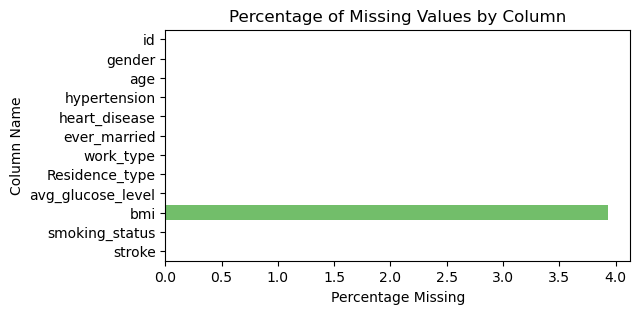

In [4]:
## YOUR CODE HERE
missing_percentage = (health_df.isnull().sum() / len(health_df)) * 100
missing_info = pd.DataFrame({'Column': health_df.columns,'MissingPercentage': missing_percentage})
plt.figure(figsize=(6, 3))
sns.barplot(x='MissingPercentage', y='Column', data=missing_info, palette='viridis')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Percentage Missing')
plt.ylabel('Column Name')

Given the percentage of missing value graph, we can see that the bmi column has about 4% of missing values and the rest of columns have 0%.
Therefore, I wouldn't consider dropping columns when training the decision tree, because the percentage is rather low and this variable is intuitively highly relevant with our preditction target.
I would consider drop the rows with missing values in order to keep the overall distribution unaffected.

**Check for the number of rows after handling null values, each column should have the same number of non-null count**

In [5]:
## YOUR CODE HERE
health_df.dropna(inplace=True)
num_rows, num_columns = health_df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 4909
Number of columns: 12


**1.3 Print the distribution of the target variable. Is the dataset balanced?**

In [6]:
## YOUR CODE HERE
target_counts = health_df['stroke'].value_counts()
category_probabilities = target_counts / target_counts.sum()
print(category_probabilities)

0    0.957425
1    0.042575
Name: stroke, dtype: float64


**Your Comments Here**:

It is not a balanced dataset because the majority, which is nearly 95.7% of all the data points fall into the category of 0, which is not having a stroke.

**1.4: Plot side-by-side bars of class distribtuion for each category for the categorical feature and the target categories.**

**Clarification with Example below : Here `flWinner` is the Target Variable and `descMapName` is a categorical feature. You are required to make such side-by-side bar plot for each categorical feature with repect to it's class distribution with the target feature for our dataset.**

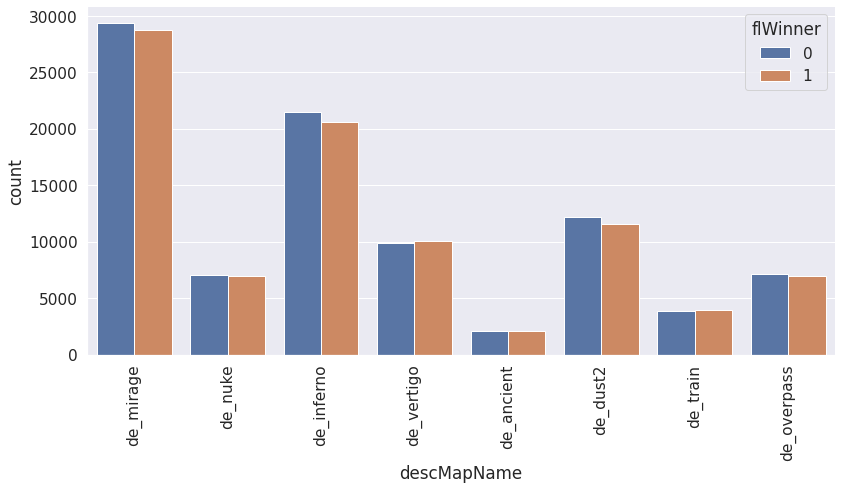

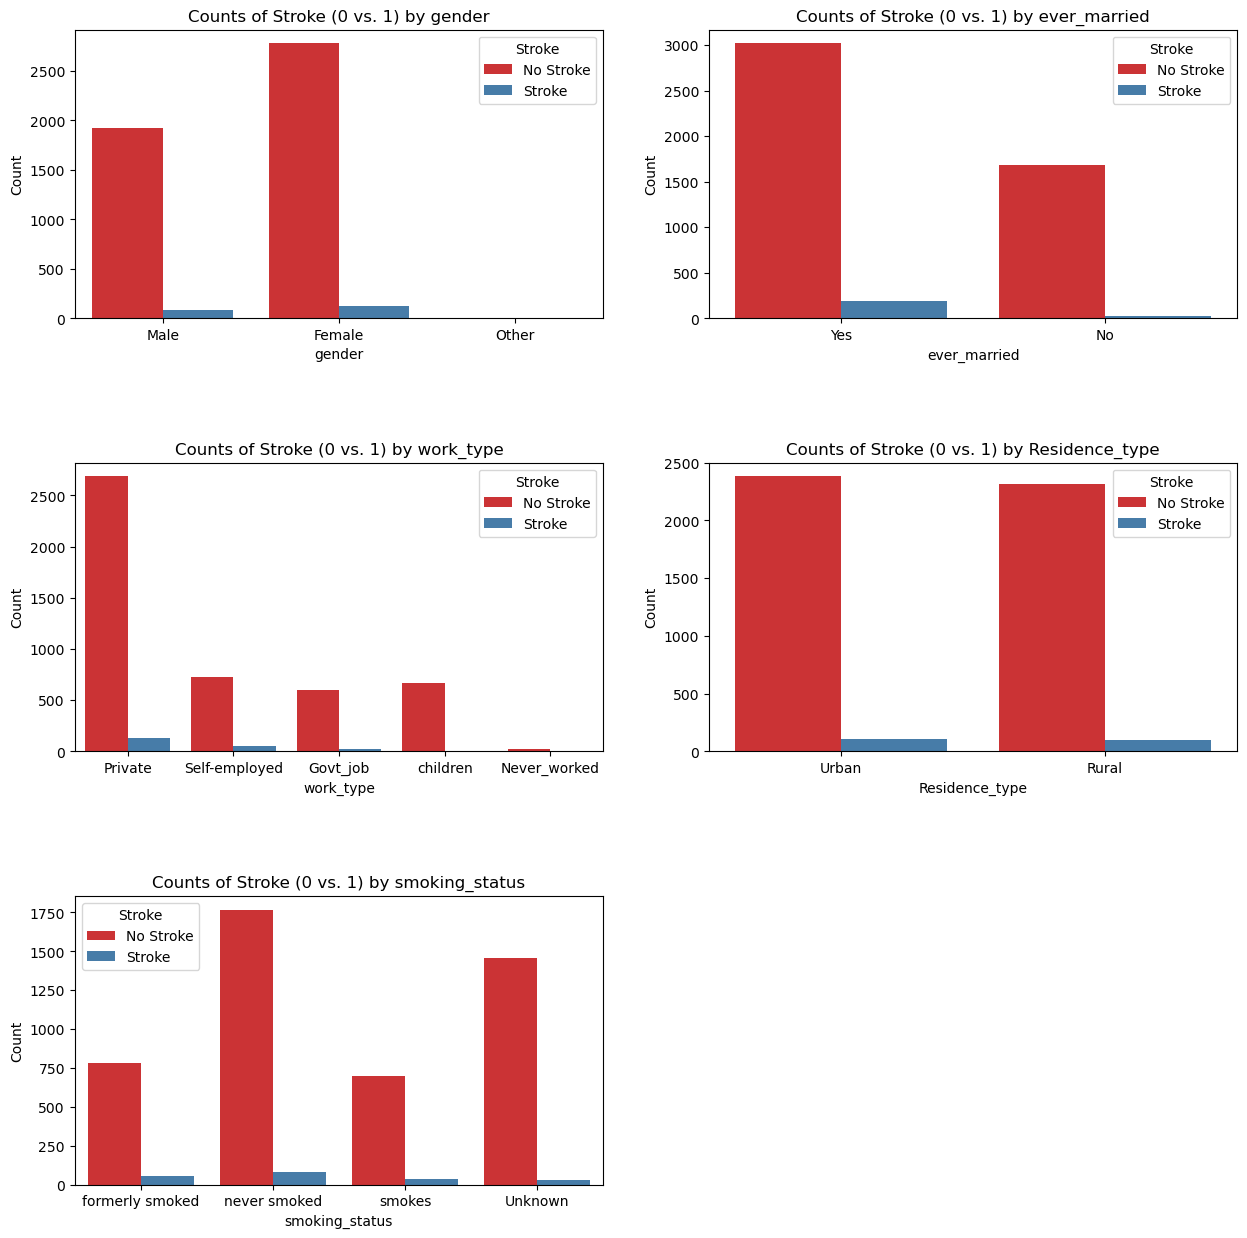

In [7]:
# Your code here
Categorical_features = ['gender', 'ever_married','work_type','Residence_type','smoking_status']
Target_feature = health_df['stroke']

num_features = len(Categorical_features)
num_rows = (num_features + 2) // 2

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 5 * num_rows))
plt.subplots_adjust(hspace=0.5)

for i, feature in enumerate(Categorical_features):
    row, col = i // 2, i % 2 
    ax = axes[row, col]

    sns.countplot(x=feature, hue=Target_feature, data=health_df, palette='Set1', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.set_title(f'Counts of Stroke (0 vs. 1) by {feature}')
    ax.legend(title='Stroke', labels=['No Stroke', 'Stroke'])

for i in range(num_features, num_rows * 2):
    row, col = i // 2, i % 2
    fig.delaxes(axes[row, col])

**1.5: Preprocess the data (Handle the Categorical Variable). Do we need to apply scaling? Briefly Justify.**

In [6]:
df_X = health_df.drop(columns=['stroke','id'])
df_Y = health_df['stroke'].astype(int)

## YOUR CODE HERE
encoder = OneHotEncoder
df_X = pd.get_dummies(df_X, drop_first=True)

**Your Comments Here**:

We don't need to apply the scaling because the decision trees can handle the categorical variables as it is, and they are invariant to scale of data, so there is no point to scale any variables. 

**1.6: Split the data into development and test datasets. Which splitting methodology did you choose and why?**

In [7]:
## YOUR CODE HERE

X_dev, X_test, y_dev, y_test = train_test_split(df_X, df_Y, test_size=0.2, stratify=df_Y, random_state=42)

**Your Comments Here**:

I choose to use stratified splitting because the given dataset is highly imbalanced, and the stratified splitting can make sure that the ratio of indices for classes in development and test datasets equals that of the original datasets. 

**1.7: Fit a Decision Tree on the training data until all leaves are pure. What is the performance of the tree on the development set and test set? Provide metrics you believe are relevant and briefly justify.**


**HINT : Think about the proportion of the class label**

In [8]:
## YOUR CODE HERE
initial_tree = DecisionTreeClassifier(criterion="entropy", splitter="best")
initial_tree.fit(X_dev, y_dev)

y_pred = initial_tree.predict_proba(X_test)
auc_score = roc_auc_score(y_pred[:,1], y_test)
print("roc_auc Score: {:.4f}".format(auc_score))

roc_auc Score: 0.5302


**Your Comments Here**

For this problem I used the area under the roc cureve (roc_auc) score as the evaluation metrics. This is because of all the metrics that are suitable for imbalanced dataset, roc_auc score can help us to better see how well the model separates the two groups, which is important in this case for concerning health risk. 

The roc-auc score for this decision tree is is 0.5302, and it is a rather undesirable value as it means that the curve lies only a little above the diagnal line of seperating false positive and true posistive, suggesting a large room for improvement for the performance of model.

**1.8: Visualize the trained tree until the max_depth 8**

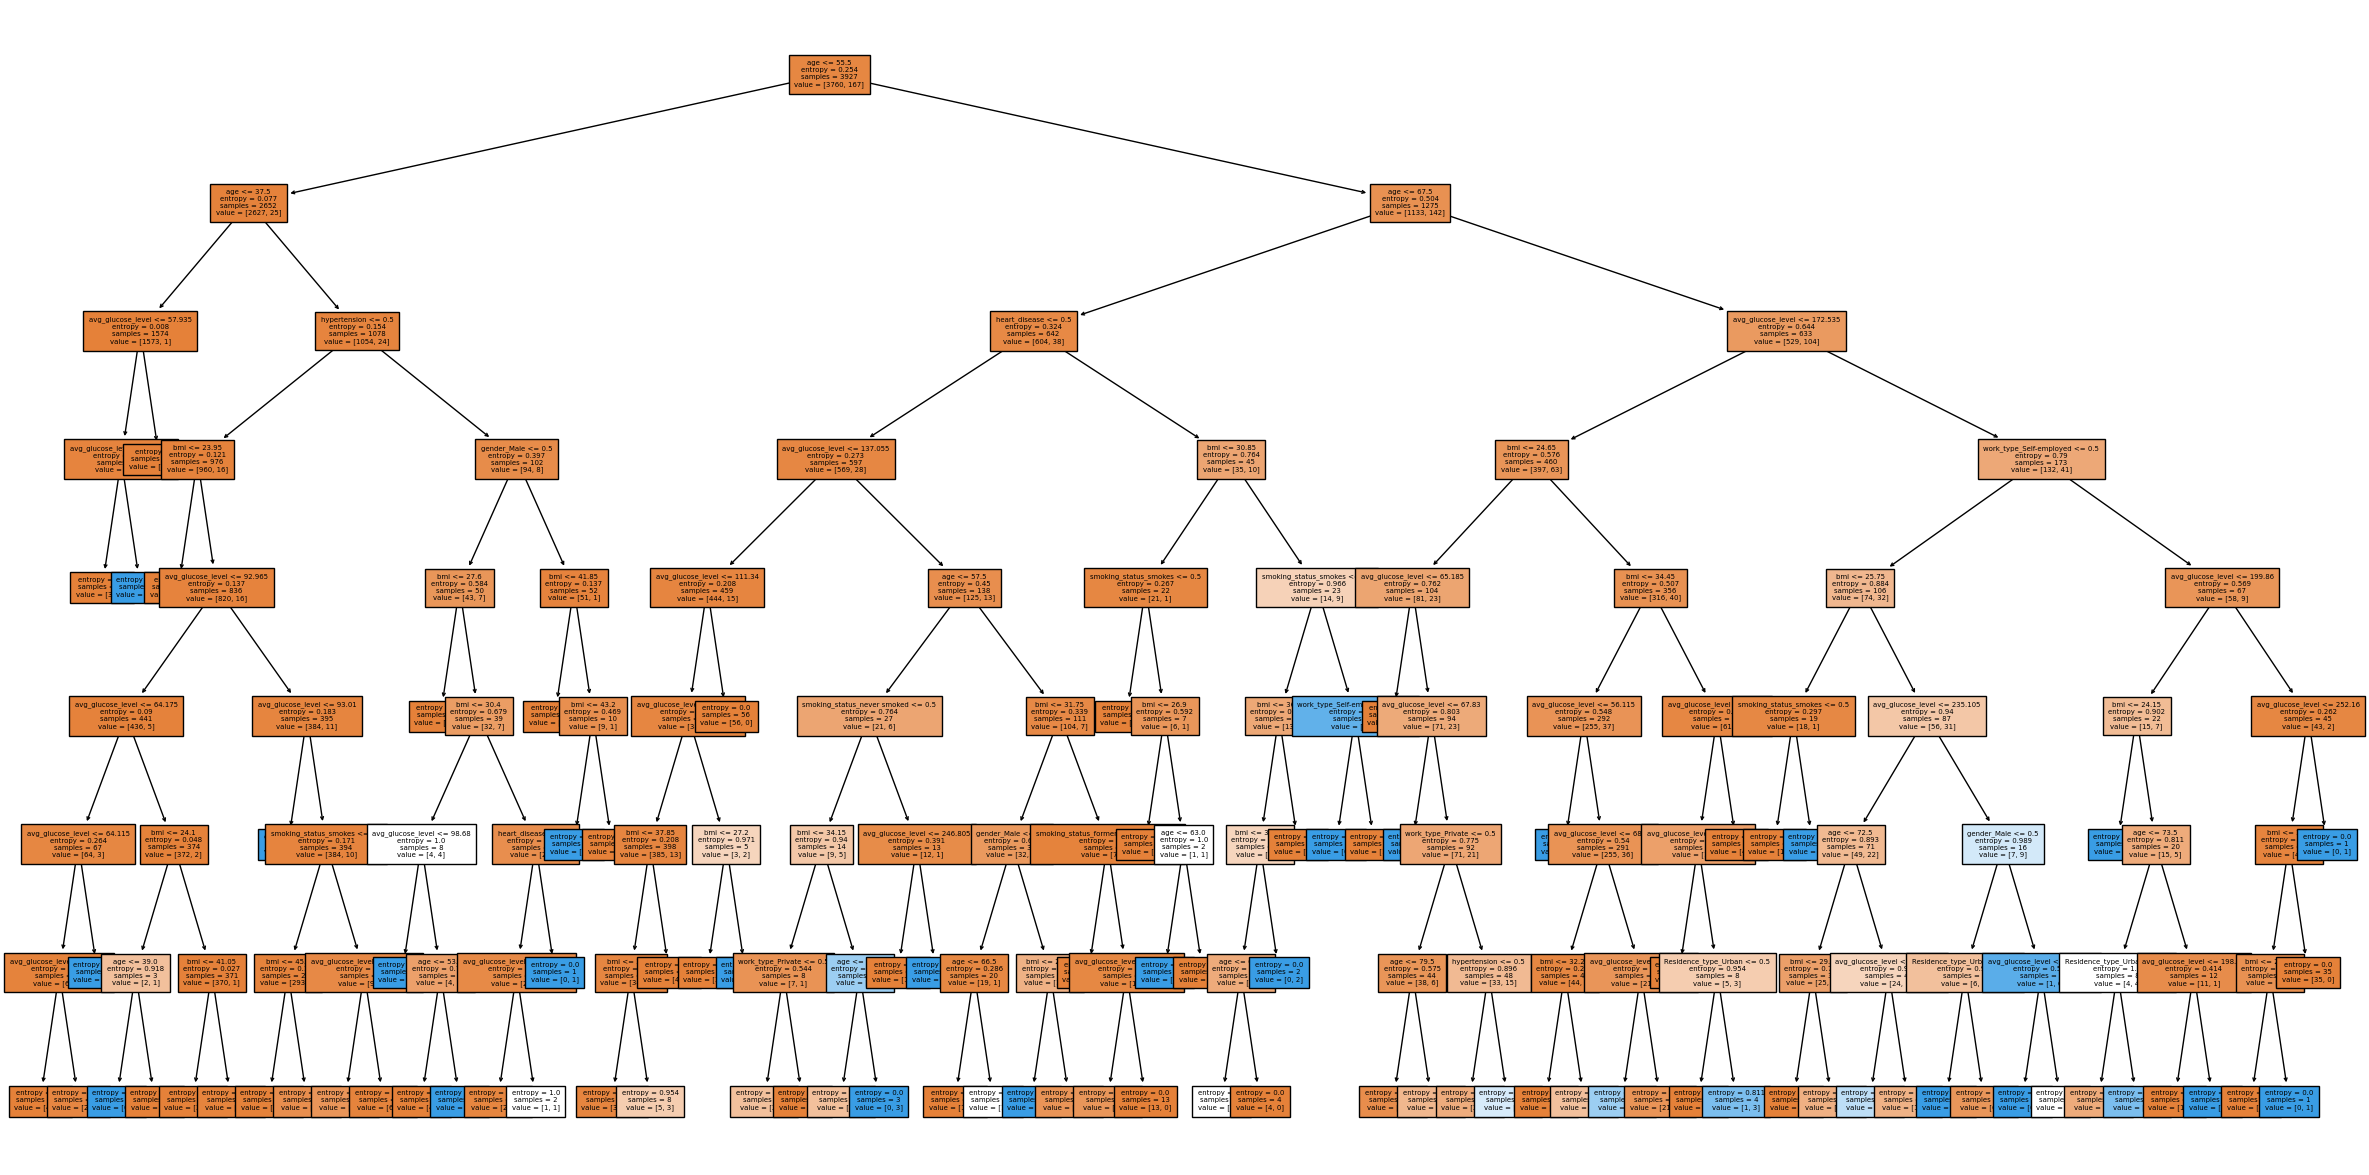

In [11]:
## YOUR CODE HERE

EarlyStop_tree = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=8)
EarlyStop_tree.fit(X_dev, y_dev)

plt.figure(figsize=(30, 15))
plot_tree(EarlyStop_tree, filled=True, feature_names=df_X.columns.to_list(),fontsize=5)
plt.show()

**1.9: Prune the tree using one of the techniques discussed in class and evaluate the performance. Carefully consider which metric to use considering the imbalance in the class label.**

In [9]:
## YOUR CODE HERE

path = initial_tree.cost_complexity_pruning_path(X_dev, y_dev)
alphas = path['ccp_alphas']
pruned_trees = []

for alpha in alphas:
    pruned_tree = DecisionTreeClassifier(random_state=8, ccp_alpha=alpha)
    pruned_tree.fit(X_dev, y_dev)
    pruned_trees.append(pruned_tree)

# Evaluate the performance of pruned trees using roc_auc score
Roc_auc_scores= []
for tree in pruned_trees:
    y_pred = tree.predict_proba(X_test)
    Roc_auc_score = roc_auc_score(y_test, y_pred[:,1])
    Roc_auc_scores.append(Roc_auc_score)

# Find the index of the best roc_auc score
best_roc_auc_index = np.argmax(Roc_auc_score)

# Get the corresponding alpha for the best tree
best_alpha = alphas[best_roc_auc_index]

# Print the best alpha
print("Best Alpha:", best_alpha)

# Select the pruned tree with the highest roc_auc score
best_pruned_tree = pruned_trees[np.argmax(Roc_auc_score)]

def get_tree_info(tree):
    depth = tree.tree_.max_depth
    num_nodes = tree.tree_.node_count
    return depth, num_nodes

# Get depth and number of nodes for the initial tree
initial_depth, initial_nodes = get_tree_info(initial_tree)
print("Initial Tree Depth:", initial_depth)
print("Initial Tree Number of Nodes:", initial_nodes)

# Get depth and number of nodes for the best pruned tree
best_pruned_depth, best_pruned_nodes = get_tree_info(best_pruned_tree)
print("Best Pruned Tree Depth:", best_pruned_depth)
print("Best Pruned Tree Number of Nodes:", best_pruned_nodes)

# Evaluate the final pruned tree on the test set
y_pred_final = best_pruned_tree.predict_proba(X_test)
Final_roc_auc_score = roc_auc_score(y_test, y_pred_final[:,1])
print("roc_auc Score: {:.4f}".format(Final_roc_auc_score))

Best Alpha: 0.0
Initial Tree Depth: 21
Initial Tree Number of Nodes: 469
Best Pruned Tree Depth: 20
Best Pruned Tree Number of Nodes: 505
roc_auc Score: 0.5517


**Your Comments Here**

I chose the roc_auc score as the evaluation metric due to the reasons stated in the above question. 

**1.10: List the top 3 most important features for this trained tree? How would you justify these features being the most important?**

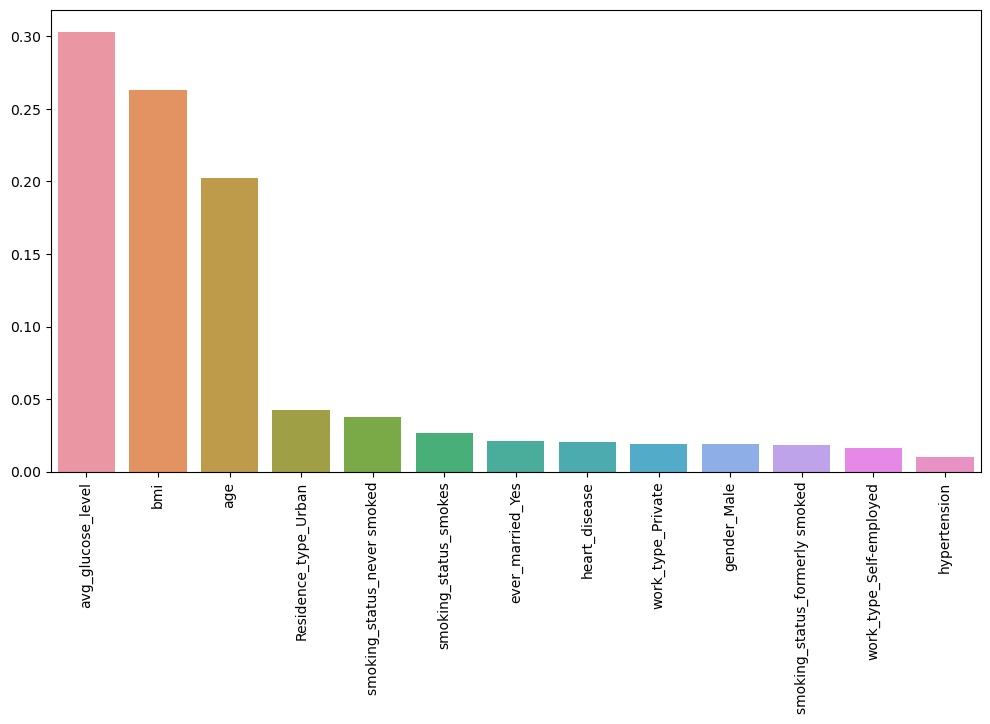

In [13]:
num_features = [] 
ohe_feature_names = df_X.columns.tolist()
te_feature_names = [df_Y.name]
feature_names = num_features + ohe_feature_names + te_feature_names
feat_imps = zip(feature_names, best_pruned_tree.feature_importances_)

feats, imps = zip(*sorted(filter(lambda x: x[1] > 0, feat_imps), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)

**Your Comments Here**

The top 3 features are the average glucose level, bmi, and age. These features being the most important ones make sense because they are all commonly seen health indicators that can directly affect one's overal health condition. Especially, the high level of glucose, high bmi which stands for obesity, and older in age repersent negative health aspect, so it make sensen that they would contribute to the potential of getting a stroke.

## Question 2: Random Forests

**2.1: Train a Random Forest model on the development dataset using RandomForestClassifier class in sklearn. Use the default parameters. Evaluate the performance of the model on test dataset. Does this perform better than Decision Tree on the test dataset (compare to results in Q 1.6)?**

In [10]:
## YOUR CODE HERE
from sklearn.ensemble import RandomForestClassifier

RandomForest = RandomForestClassifier(random_state=8)
RandomForest.fit(X_dev, y_dev)

y_pred_rf = RandomForest.predict_proba(X_test)

print("Random Forest roc_auc Score:")
print(roc_auc_score(y_test, y_pred_rf[:,1]))


Random Forest roc_auc Score:
0.7550785207700101


**Your Comments Here**

According to the roc_auc score, it is increased from approximately 0.53 to 0.755, which is a big improvement that means that the model is much better at seperating the positive and negative classes and hence it is certianly a sign for better performance than the decision tree. 

**2.2: Does all trees in the trained random forest model have pure leaves? How would you verify this?**

In [15]:
### YOUR CODE HERE

def gini_impurity(class_labels):
    if len(class_labels) == 0:
        return 0.0  # Pure if there are no samples in the node
    total_samples = len(class_labels)
    class_counts = np.bincount(class_labels)
    probabilities = class_counts / total_samples
    return 1.0 - np.sum(probabilities**2)

def is_tree_pure(tree, X_test_leaves, y_test, threshold=0.0):
    leaf_nodes = tree.apply(X_test_leaves)

    for node_id in leaf_nodes:
        class_labels = y_test  # Use the entire class labels array
        if gini_impurity(class_labels) > threshold:
            return False  # Impure leaf found in this tree

    return True  # All leaves are pure in this tree


X_test_leaves = X_test.to_numpy().astype(np.float32)

all_trees_pure = all(
    is_tree_pure(tree, X_test_leaves, y_test, threshold=0.0)
    for tree in RandomForest
)

if all_trees_pure:
    print("All trees in the random forest have pure leaves.")
else:
    print("At least one tree in the random forest has impure leaves.")

At least one tree in the random forest has impure leaves.


**Your Comments Here**

**2.3: Assume you want to improve the performance of this model. Also, assume that you had to pick two hyperparameters that you could tune to improve its performance. Which hyperparameters would you choose and why?**


In [86]:
## YOUR CODE HERE

param_dist = {
    'n_estimators'
    'max_depth'
}

**Your Comments Here**

I would choose the number of trees and maximum depth of the tree because they are most relevent to the shpae of the tree and hence how to classify a data point, and they are two of the most commonly seen parameters for tuning. 

**2.4: Now, assume you had to choose up to 5 different values (each) for these two hyperparameters. How would you choose these values that could potentially give you a performance lift?**

**Your Comments Here**

In [17]:
## YOUR ANSWER HERE

For Number of estimators, the values I chose are [100,200,300,400,500], and that is because the number of nodes we have for initial tree is 421 and the number for tuned tree is 505, so I want to build the forest around that range of value with potentially as less nodes as possible to prevent overfitting and also to improve the performance.

For the max depth, the values I chose are [5,10,15,20,25], considering the depth of initial tree as 21 and the experimentation of 8 max_depth in the previous question, so I build the range of values around that. 

**2.5: Perform model selection using the chosen values for the hyperparameters. Use cross-validation for finding the optimal hyperparameters. Report on the optimal hyperparameters. Estimate the performance of the optimal model (model trained with optimal hyperparameters) on test dataset? Has the performance improved over your plain-vanilla random forest model trained in Q2.1?**

In [87]:

# Define hyperparameters to search
param_dist = {
    'n_estimators': [100,200,300,400,500],
    'max_depth': [5,10,15,20,25]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=8)

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, cv=5, n_iter=100, scoring='roc_auc', n_jobs=-1, random_state=11
)
random_search.fit(X_dev, y_dev)

# Train the model with the best hyperparameters
best_rf = random_search.best_estimator_
best_rf.fit(X_dev, y_dev)

# Evaluate the model on the test dataset
y_pred_rf = best_rf.predict_proba(X_test)
rf_auc = roc_auc_score(y_test, y_pred_rf[:,1])

print("Optimal Hyperparameters:", random_search.best_params_)
print("Roc_auc score with the Best Model:", rf_auc)

Optimal Hyperparameters: {'n_estimators': 300, 'max_depth': 5}
Roc_auc score with the Best Model: 0.7826494427558257


**Your Comments Here**

By the score of aoc_roc, this model with tuned hyperparamter has a score of approximately 0.78, which is clearly higher than the previous model, indicating the improvment in the model performance. 

**2.6: Can you find the top 3 most important features from the model trained in Q2.5? How do these features compare to the important features that you found from Q1.9? If they differ, which feature set makes more sense?**

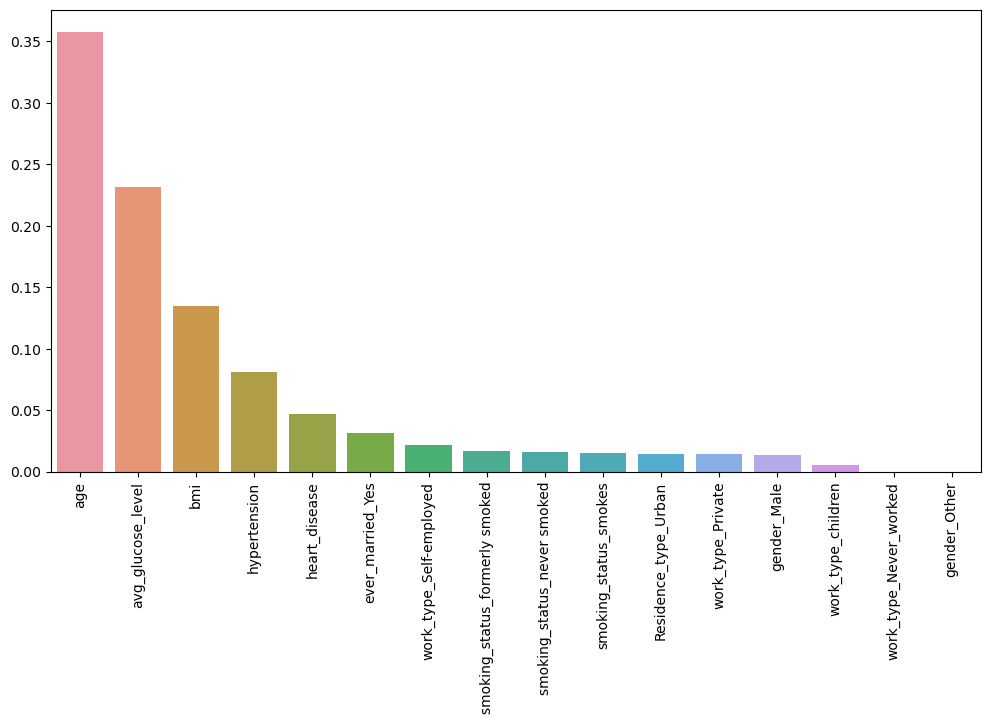

In [51]:
## YOUR CODE HERE
num_features = [] 
ohe_feature_names = df_X.columns.tolist()
te_feature_names = [df_Y.name]
feature_names = num_features + ohe_feature_names + te_feature_names
feat_imps = zip(feature_names, best_rf.feature_importances_)

feats, imps = zip(*sorted(filter(lambda x: x[1] > 0, feat_imps), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)
plt.show()

**Your Comments Here**

For this model, the top three features are still age, glucose and bmi. However, the order of their importance changes as the most important one is age instead of glucose level in this model. I think the features in last model make more sense to me as glucose level gives a more direct and reasonable measure of the bodily functioning while age could be biased in measuing the biological functioning. 

## Question 3: Gradient Boosted Trees

**3.1: Choose three hyperparameters to tune GradientBoostingClassifier and HistGradientBoostingClassifier on the development dataset using 5-fold cross validation.  
You can use GridSearchCV, however make sure to use appropriate metric for the scoring parameter of GridSearchCV.  
Report on the time taken to do model selection for both the models. Also, report the performance of the test
dataset from the optimal models.**

In [53]:
## YOUR CODE HERE

# Choose value range for hyperparameters
param_gb = {
    'n_estimators': [100,300,500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5,10,20],
}

# Initialize the GradientBoostingClassifier
gb_classifier = GradientBoostingClassifier(random_state=8)

# Perform GridSearchCV with 5-fold cross-validation to find best hyperparameters
grid_search_gb = GridSearchCV(gb_classifier, param_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_gb.fit(X_dev, y_dev)

#Train the model on the best hyperparameters
best_gb = grid_search_gb.best_estimator_
y_pred_gb = best_gb.predict_proba(X_test)
gb_auc = roc_auc_score(y_test,y_pred_gb[:, 1],)

# Print the best parameters and their corresponding score
print("Best Parameters for GradientBoostingClassifier:", grid_search_gb.best_params_)
print("Best Score for best model:", gb_auc)

Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Best Score for GradientBoostingClassifier: 0.7849797365754813


In [61]:

# Choose value range for hyperparameters
param_hist_gb = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10,20,30],
    'max_bins': [10, 50, 100]
}

# Initialize the HistGradientBoostingClassifier
hist_gb_classifier = HistGradientBoostingClassifier(random_state=8)

# Perform GridSearchCV with 5-fold cross-validation to find best hyperparameters
grid_search_hist_gb = GridSearchCV(hist_gb_classifier, param_hist_gb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_hist_gb.fit(X_dev, y_dev)

#Train the model on the best hyperparameters
best_hist_gb = grid_search_hist_gb.best_estimator_
y_pred_hist = best_hist_gb.predict_proba(X_test)
hist_auc = roc_auc_score(y_test,y_pred_hist[:,1])

# Print the best parameters and their corresponding score
print("Best Parameters for HistGradientBoostingClassifier:", grid_search_hist_gb.best_params_)
print("Roc_auc Score for Best model:", hist_auc)

Best Parameters for HistGradientBoostingClassifier: {'learning_rate': 0.01, 'max_bins': 10, 'max_depth': 20}
Roc_auc Score for Best model: 0.7899316109422493


**Your Comments Here** :

Time used for GradientBoostingClassifier: 6m 45.5s

Time used for HistGradientBoostingClassifier: 51.8s

**3.2: Train an XGBoost model by tuning 3 hyperparameters using 10 fold cross-validation. Compare the performance of the trained XGBoost model on the test dataset against the performances obtained from 3.1**

In [60]:
## YOUR CODE HERE
param_xgb = {
    'n_estimators': [100,300,500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5,10,20],
}

# Initialize the HistGradientBoostingClassifier
xgb_classifier = XGBClassifier(seed=8)

# Perform GridSearchCV with 10-fold cross-validation
grid_search_xgb = GridSearchCV(xgb_classifier, param_xgb, cv=10, scoring='roc_auc', n_jobs=-1)
grid_search_xgb.fit(X_dev,y_dev)

# Train the model with the best hyperparameters
best_xgb = grid_search_xgb.best_estimator_
y_pre_xgb = best_xgb.predict_proba(X_test)
auc_xgb = roc_auc_score(y_test,y_pre_xgb[:,1])

# Print the best parameters and their corresponding score
print("Best Parameters for XGBClassifier:", grid_search_xgb.best_params_)
print("Best Auc Score for XGBClassifier:", auc_xgb)

Best Parameters for XGBClassifier: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Best Auc Score for XGBClassifier: 0.8019883485309016


**Your Comments Here** :



The XGBoost model has a better performance given a higher roc_auc score of approximately 0.8. This is expected because xgboost adds l1 and l2 penalties on leaf weights and has monotonicity & feature interaction constraints to improve the model as comparing to the models in the question 3.1

**3.3: Can you list the top 3 features from the trained XGBoost model? How do they differ from the features found from Random Forest and Decision Tree? Which one would you trust the most?**

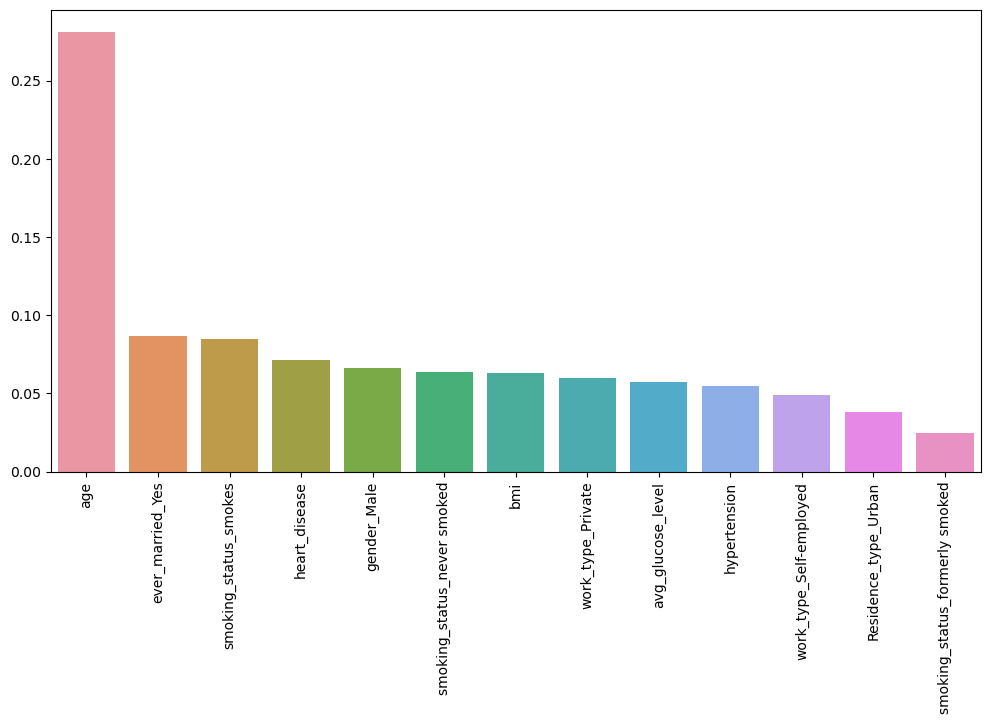

In [62]:
## YOUR CODE HERE
num_features = [] 
ohe_feature_names = df_X.columns.tolist()
te_feature_names = [df_Y.name]
feature_names = num_features + ohe_feature_names + te_feature_names
feat_imps = zip(feature_names, best_xgb.feature_importances_)

feats, imps = zip(*sorted(filter(lambda x: x[1] > 0, feat_imps), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=list(feats), y=list(imps))
ax.tick_params(axis='x', rotation=90)
plt.show()

**Your Comments Here**

The top 3 features are age, ever_married_yes, and smoking_status_smokes. This make sense to me as these three features are very relevent with the overall life style choices of individuals and can potentially reflect both menatl and physical health condition. I would trust this one more in predicting the stroke because it reflects a wider range of causes rather than purly medical health indicators.  

**3.4: Can you choose the top 7 features (as given by feature importances from XGBoost) and repeat Q3.2? Does this model perform better than the one trained in Q3.2? Why or why not is the performance better?**

In [68]:
## YOUR CODE HERE

top_7_features = ['age','ever_married_Yes','smoking_status_smokes','heart_disease','gender_Male','smoking_status_never smoked','bmi']

df_X_new = df_X[top_7_features]
df_y_new = df_Y.loc[df_X_new.index]

X_dev_new, X_test_new, y_dev_new, y_test_new = train_test_split(df_X_new, df_y_new, test_size=0.2, stratify=df_Y, random_state=8)

# Train the model with the best hyperparameters
xgb_new = grid_search_xgb.fit(X_dev_new,y_dev_new)
best_xgb_new = xgb_new.best_estimator_
y_pre_xgb_new = best_xgb_new.predict_proba(X_test_new)
auc_xgb_new = roc_auc_score(y_test_new,y_pre_xgb_new[:,1])

# Print the score
print("Best Auc Score for XGBClassifier:", auc_xgb)


Best Auc Score for XGBClassifier: 0.8019883485309016


**Your comments here**

Given the roc_auc score as the evaluation metric, there isn't a distinct improvement between these two models. It might because that these 7 features play significant role in contributing to the classification threshold so that whether the rest features are in presense or not can hardly impact the performance of the model.

**3.5: Compare the results on the test dataset from XGBoost, HistGradientBoostingClassifier, GradientBoostingClassifier with results from Q1.6 and Q2.1. Which model tends to perform the best and which one does the worst? How big is the difference between the two? Which model would you choose among these 5 models and why?**

According to the evaluation score, XGBoost has the best performance in classifying two classes, and its auc_roc score of approximatly 0.8 has increased about 50.9% comparing to the initial classification tree with all pure leafs, which is the worst model among all. Therefore, I would choose this model as it has the best performance in its predicting power.

## Question 4: Calibration

**4.1: Estimate the brier score for the XGBoost model (trained with optimal hyperparameters from Q3.2) scored on the test dataset.**

In [70]:
## YOUR CODE HERE

brier_score = brier_score_loss(y_test, y_pre_xgb[:,1])
print("Brier Score:", brier_score)

Brier Score: 0.0397178173235186


**4.2: Calibrate the trained XGBoost model using isotonic regression as well as Platt scaling. Plot predicted v.s. actual on test datasets from both the calibration methods. Report brier score after calibration.**

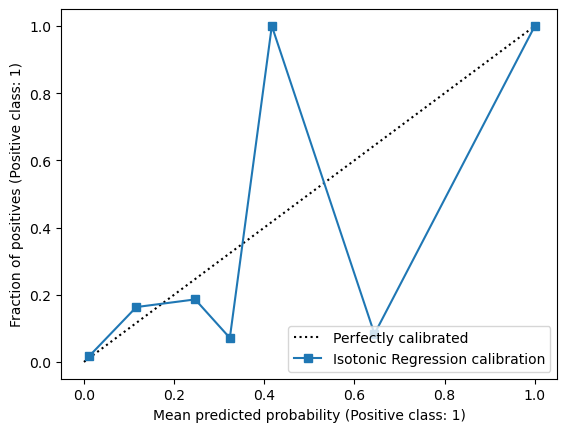

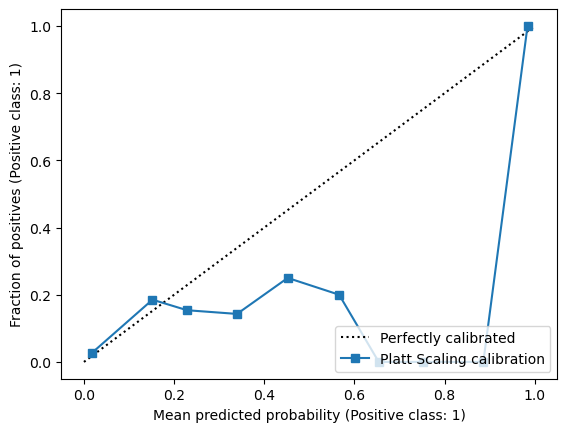

In [78]:
## YOUR CODE HERE

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

## Isotonic Regression
iso_clf = CalibratedClassifierCV(best_xgb, method='isotonic', cv='prefit')
iso_clf.fit(X_dev_new,y_dev_new)
iso_probs = iso_clf.predict_proba(X_test_new)
display = CalibrationDisplay.from_estimator(iso_clf,X_test_new,y_test_new, n_bins=10,name = 'Isotonic Regression calibration')


## Platt Scaling 
platt_clf = CalibratedClassifierCV(best_xgb, method='sigmoid', cv='prefit')
platt_clf.fit(X_dev_new,y_dev_new)
platt_probs = platt_clf.predict_proba(X_test_new)
display = CalibrationDisplay.from_estimator(platt_clf,X_test_new,y_test_new, n_bins=10,name = 'Platt Scaling calibration')


**4.3: Report brier scores from both the calibration methods. Do the calibration methods help in having better predicted probabilities?**

In [89]:
## YOUR CODE HERE

iso_brier_score = brier_score_loss(y_test, iso_probs[:,1])
platt_brier_score = brier_score_loss(y_test, platt_probs[:,1])

#print brier scores
print(f'Isotonic Calibration Brier Score: {iso_brier_score}')
print(f'Platt Scaling Calibration Brier Score: {platt_brier_score}')

# Print the roc_auc score
print("Auc Score for Isotonic Calibration :", roc_auc_score(y_test_new,iso_probs[:,1]))
print("Auc Score for Platt Scaling Calibration :", roc_auc_score(y_test_new,platt_probs[:,1]))

Isotonic Calibration Brier Score: 0.051010747536952394
Platt Scaling Calibration Brier Score: 0.05096399602857898
Auc Score for Isotonic Calibration : 0.8570415400202633
Auc Score for Platt Scaling Calibration : 0.8555091185410334


The calibration method effetively helped with the model performance, which is indicated by the increase in the auc score from 0.8 to 0.857 and 0.855. In between these two calibration methods, it appears that Isotonic Calibration is more effetive. 